## **Hands-on: molecular data reading**

**Name: Carolina Gomes**


**RA: 122028**

This report details the steps of the QM9 dataset analysis script, providing additional context and insights based on scientific literature.

**STEP 1: Install and import the necessary libraries**

The first step in the script is to set up the environment, which involves installing and importing essential libraries. The choice of these libraries is strategic for the task of chemoinformatics:

1.   ***rdkit:*** One of the leading open-source libraries in chemoinformatics. It is essential for working with molecular structures, enabling the validation and canonicalization of SMILES. Validation ensures that the notation is chemically plausible, while canonicalization ensures that each molecule has a unique and standardized SMILES representation, which is crucial to avoid duplication and facilitate searching.
2.   ***pandas:*** The standard library for data manipulation and analysis in Python. It allows us to store data extracted from hundreds of thousands of text files in an efficient and easy-to-use table structure known as DataFrame.
3.   ***matplotlib and seaborn:*** Two powerful libraries for data visualization. They are essential for the Exploratory Data Analysis (EDA) stage, transforming raw data into graphs and heat maps that facilitate the identification of patterns and distributions.
4.  ***requests and tqdm:*** Libraries for downloading the dataset from a URL and displaying a progress bar, respectively, ensuring a more informative user experience during data extraction.

In [50]:
# Installing the required libraries
!pip install requests tqdm rdkit -q

import os
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit libraries for molecular processing
from rdkit import Chem
from rdkit.Chem import Descriptors

print("Libraries successfully installed and imported.")

Libraries successfully installed and imported.


**STEP 2: Auxiliary functions for downloading and processing.**

The script performs one of the most critical steps of the project: downloading and parsing the QM9 dataset, which contains quantum chemistry data for approximately 134,000 molecules. The dataset is in an .xyz file format, which is a common standard in the field.

The .xyz format is structured as follows:

1. The first line indicates the number of atoms in the molecule.
2. The second line contains theoretically calculated molecular properties, such as rotational constants, dipole moment, HOMO and LUMO energies, among others.
3. The following lines list the atomic coordinates of each atom.
4. The last lines contain SMILES and InChI information, which are character strings that describe the molecular structure.



In [51]:
def download_file(url, save_path):
    print(f"Downloading '{os.path.basename(save_path)}'...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            with open(save_path, 'wb') as f, tqdm(
                desc=os.path.basename(save_path),
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error during the download of {url}: {e}")
        return False

def unpack_archive(archive_path, extract_path):
    print(f"Extracting '{os.path.basename(archive_path)}'...")
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            with tarfile.open(archive_path, 'r:bz2') as tar:
                tar.extractall(path=extract_path)
        print("Extraction completed.")
        os.remove(archive_path)
    except (tarfile.TarError, OSError) as e:
        print(f"Error while extracting {archive_path}: {e}")

def process_xyz_file(file_path):
    PROPERTY_NAMES = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Basic file format validation
        if len(lines) < 4: return None
        num_atoms_from_file = int(lines[0])
        if len(lines) < num_atoms_from_file + 4: return None

        # SMILES validation with RDKit
        smiles_raw, _ = lines[num_atoms_from_file + 3].split()
        mol = Chem.MolFromSmiles(smiles_raw)
        if mol is None:
            return None

        # Canonical SMILES generation
        canonical_smiles = Chem.MolToSmiles(mol)

        # Property extraction
        properties = lines[1].split()[1:]
        data = {'smiles': canonical_smiles}
        for i, prop_name in enumerate(PROPERTY_NAMES):
            if i < len(properties):
                 data[prop_name] = float(properties[i+1])

        # Extraction of composition and size features
        mol = Chem.AddHs(mol)

        data['num_atoms'] = mol.GetNumAtoms()
        data['mw'] = Descriptors.MolWt(mol)

        atom_counts = {'C': 0, 'H': 0, 'O': 0, 'N': 0, 'F': 0}
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()
            if symbol in atom_counts:
                atom_counts[symbol] += 1

        for atom, count in atom_counts.items():
            data[f'n_{atom}'] = count

        return data
    except (ValueError, IndexError, Exception):
        return None


The process_xyz_file function is the core of this step. It reads each .xyz file individually and:

1. Extracts all 15 properties from the second line of the file.
2. Extracts the raw SMILES, which is the representation of the molecule in text format.
3. Validates the SMILES with rdkit. If the string is invalid, the molecule is discarded, ensuring data integrity.
4. Generates a canonical SMILES for each valid molecule. This ensures that each molecule has a unique identifier, regardless of how the string was originally written.
5. Calculates additional characteristics, such as the number of atoms and molecular weight (mw), which are useful for future analysis.
6. Counts the occurrence of each type of atom (C, H, O, N, F) in the molecule, providing insight into its composition.



**STEP 3: Download, unzip, and create the DataFrame**


After processing all ***.xyz*** files, the ***process_all_files*** function gathers data from all valid molecules into a Pandas DataFrame.

Creating the ***DataFrame*** is a key step in transforming the raw data into a structured format, facilitating analysis. The columns of the DataFrame correspond to the extracted properties and characteristics, allowing the script to easily apply statistical and visualization operations in bulk, which would not be possible with individual text files.

In [52]:
# Definition of URLs and directories
QM9_URL = "https://ndownloader.figshare.com/files/3195389"
DOWNLOAD_DIR = "downloaded_archives"
EXTRACT_DIR = "extracted_data"
ARCHIVE_NAME = "dsgdb9nsd.xyz.tar.bz2"

# Directory creation and cleanup
os.makedirs(DOWNLOAD_DIR, exist_ok=True)
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Download and extraction execution
archive_path = os.path.join(DOWNLOAD_DIR, ARCHIVE_NAME)
if download_file(QM9_URL, archive_path):
    unpack_archive(archive_path, EXTRACT_DIR)

# Searching and processing .xyz files
print("\n--- Processing files .xyz do QM9 ---")
xyz_files = glob.glob(os.path.join(EXTRACT_DIR, '**', '*.xyz'), recursive=True)

if not xyz_files:
    print("No .xyz files found to process.")
else:
    print(f"Found {len(xyz_files)} .xyz files found. Processing...")
    all_molecule_data = []
    for xyz_file in tqdm(xyz_files, desc="Processing .xyz files"):
        data = process_xyz_file(xyz_file)
        if data:
            all_molecule_data.append(data)

    # Creation of the final DataFrame
    df_qm9 = pd.DataFrame(all_molecule_data)

    print(f"\nProcessing completed. {len(df_qm9)} valid molecules found.")
    print("\n--- Final DataFrame information ---")
    df_qm9.info()
    print("\n--- Data sample ---")
    display(df_qm9.head())

dsgdb9nsd.xyz.tar.bz2:   0%|          | 0.00/82.2M [00:00<?, ?iB/s]

Extracting 'dsgdb9nsd.xyz.tar.bz2'...
Extraction completed.

--- Processing files .xyz do QM9 ---
Found 133885 .xyz files found. Processing...


Processing .xyz files:   0%|          | 0/133885 [00:00<?, ?it/s]


Processing completed. 133885 valid molecules found.

--- Final DataFrame information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133885 entries, 0 to 133884
Data columns (total 23 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   smiles     133885 non-null  object 
 1   A          133885 non-null  float64
 2   B          133885 non-null  float64
 3   C          133885 non-null  float64
 4   mu         133885 non-null  float64
 5   alpha      133885 non-null  float64
 6   homo       133885 non-null  float64
 7   lumo       133885 non-null  float64
 8   gap        133885 non-null  float64
 9   r2         133885 non-null  float64
 10  zpve       133885 non-null  float64
 11  U0         133885 non-null  float64
 12  U          133885 non-null  float64
 13  H          133885 non-null  float64
 14  G          133885 non-null  float64
 15  Cv         133885 non-null  float64
 16  num_atoms  133885 non-null  int64  
 17  mw         1338

,smiles,A,B,C,mu,alpha,homo,lumo,gap,r2,...,H,G,Cv,num_atoms,mw,n_C,n_H,n_O,n_N,n_F
0,C1CC2C3CC1CC2C3,2.55531,1.85993,1.74987,0.1472,86.78,-0.2644,0.0754,0.3397,964.6959,...,-351.171849,-351.210046,29.557,23,122.211,9,14,0,0,0
1,C1OCC2OC1C21CO1,2.86498,1.61618,1.54714,1.5284,67.23,-0.2456,0.0748,0.3204,936.6639,...,-458.896745,-458.936001,27.793,17,128.127,6,8,3,0,0
2,c1cc(C2CN2)co1,6.06541,1.38793,1.21861,2.1030,66.99,-0.2156,0.0225,0.2381,967.7657,...,-362.649106,-362.687948,24.862,15,109.128,6,7,1,1,0
3,OCCN1CC2(O)CC12,4.14032,0.89706,0.83661,1.4920,76.09,-0.2203,0.0675,0.2878,1415.0180,...,-440.212174,-440.255885,34.200,20,129.159,6,11,2,1,0
4,NC(=O)NCC1CCC1,4.75052,0.69050,0.62593,3.5718,80.83,-0.2414,0.0593,0.3007,1791.1551,...,-420.429103,-420.475937,35.565,21,128.175,6,12,1,2,0


**STEP 4: Data visualization**



The 15 molecular properties extracted from the QM9 dataset are:

* A: Rotational constant A (in GHz).
* B: Rotational constant B (in GHz).
* C: Rotational constant C (in GHz).
* mu: Dipole moment (in Debye).
* alpha: Isotropic polarizability (in Bohr3).
* epsilon_homo: Energy of the highest occupied molecular orbital (in Hartree).
* epsilon_lumo: Energy of the lowest unoccupied molecular orbital (in Hartree).
* delta_epsilon: Energy gap between HOMO and LUMO (in Hartree).
* <R^2>: Electronic spatial extension (in Bohr2).
* zpve: Vibrational zero-point energy (in Hartree).
* U_0: Internal energy at 0 K (in Hartree).
* U: Internal energy at 298.15 K (in Hartree).
* H: Enthalpy at 298.15 K (in Hartree).
* G: Free energy at 298.15 K (in Hartree).
* Cv: Heat capacity at 298.15 K (in cal/mol·K).



The visualization step is a crucial part of exploratory data analysis. The script generates histograms for molecular properties and for composition and size characteristics.

1. ***Molecular Properties Histograms:*** The graphs show the distribution of values for properties such as HOMO/LUMO energies, dipole moment, and rotational constants. Visualizing these distributions helps identify whether the data is normally distributed, whether there are outliers, or whether the distribution is skewed.



--- Generating Histograms of Molecular Properties ---


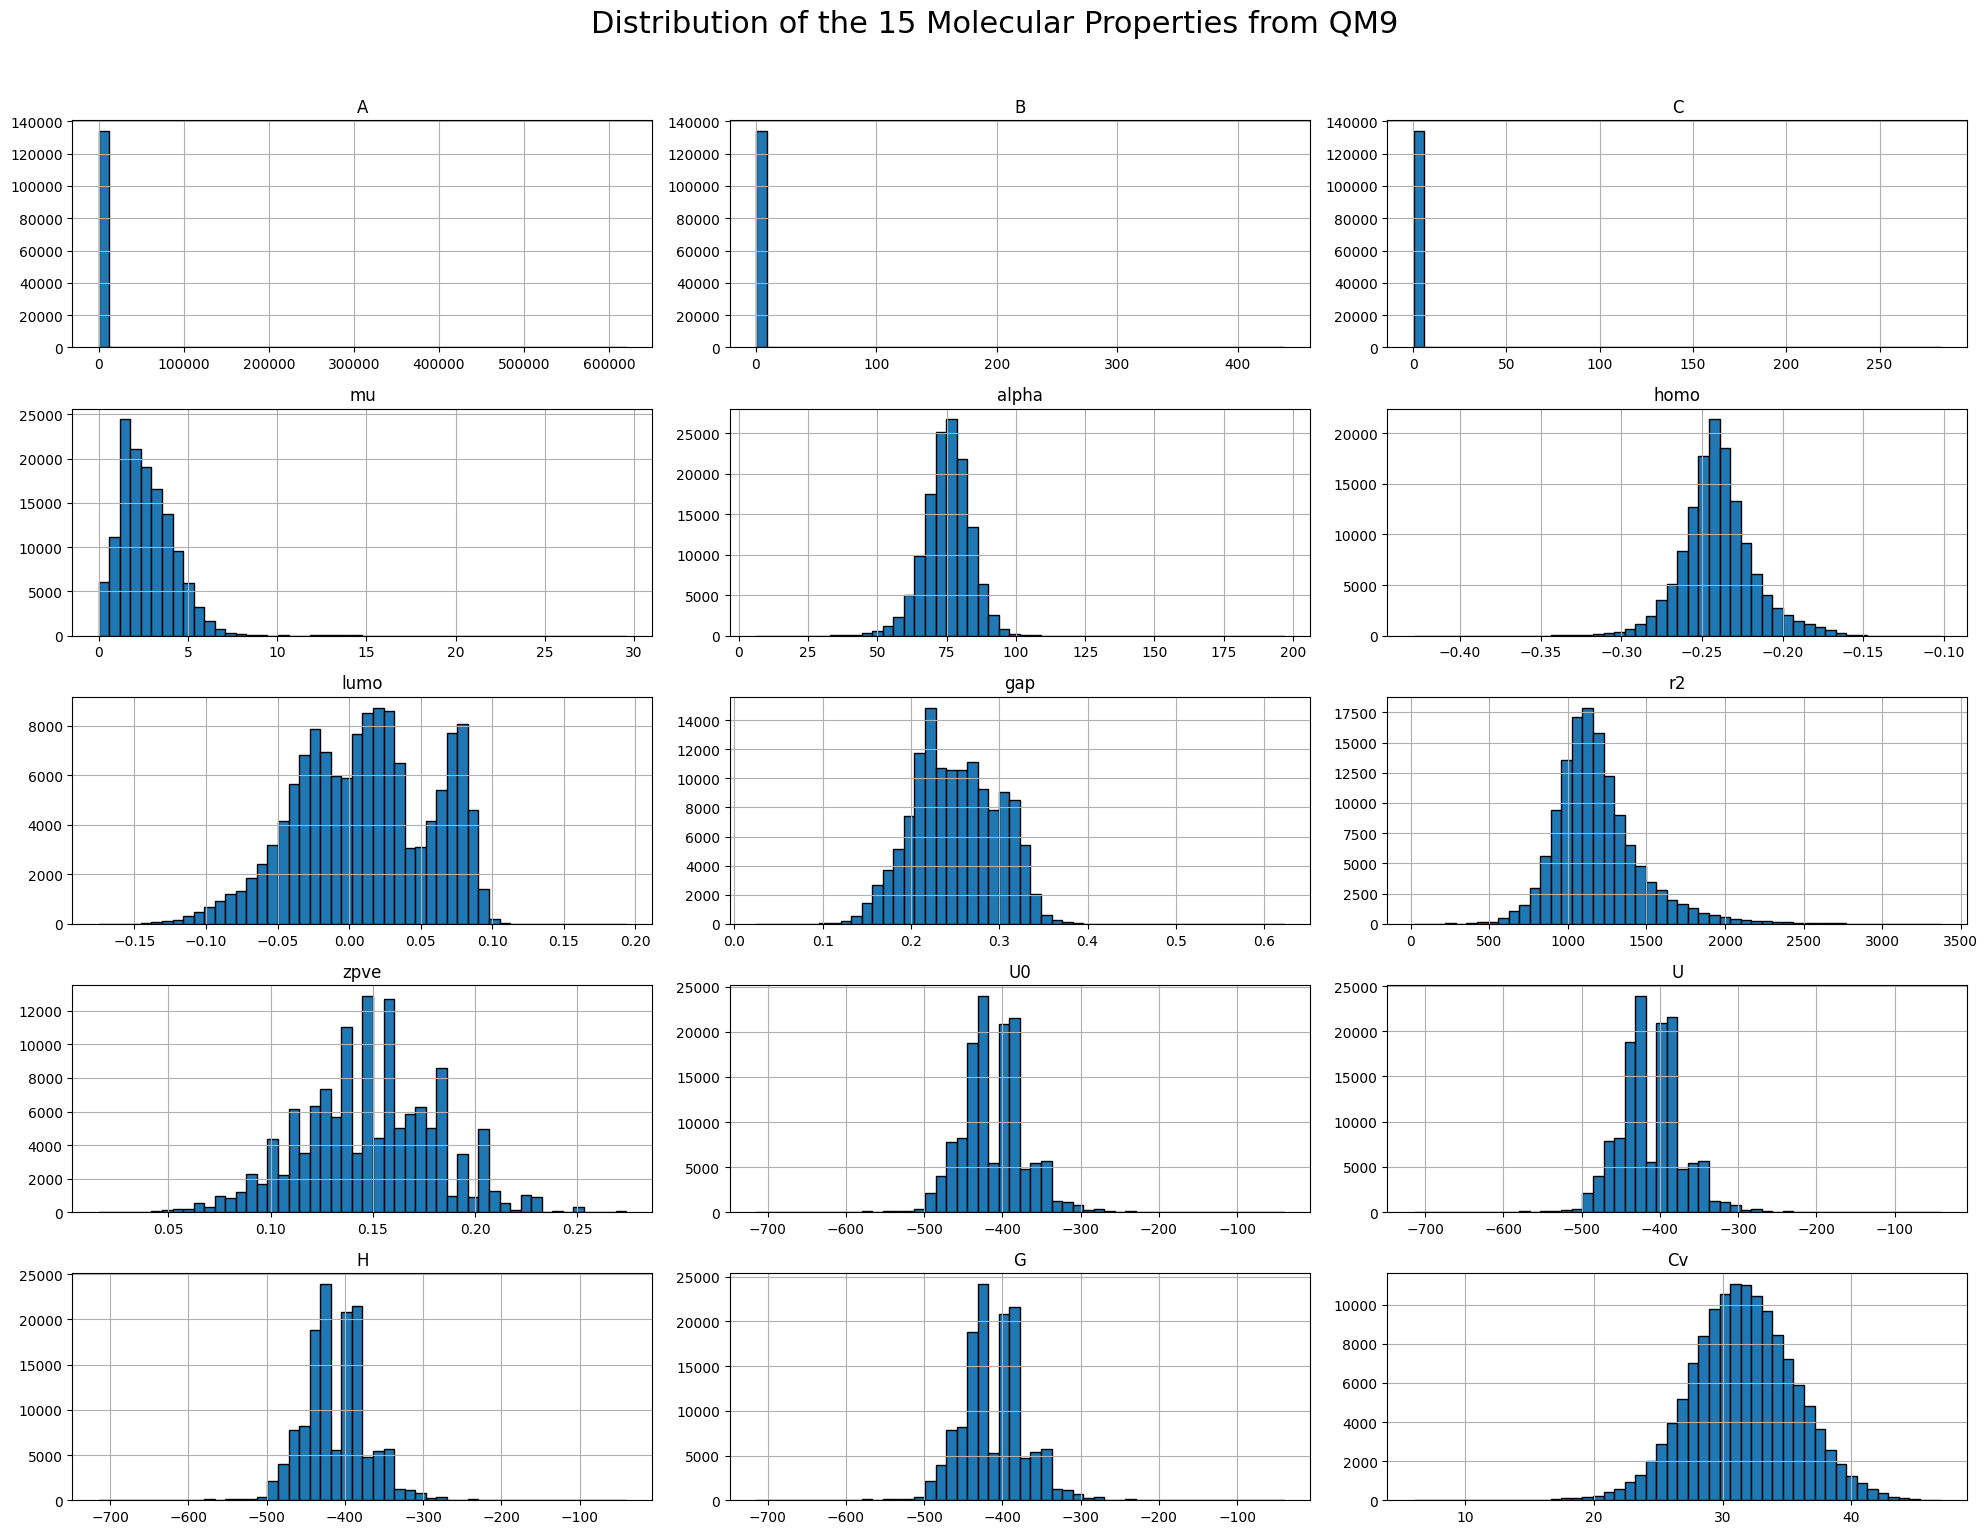

In [53]:
if not df_qm9.empty:
    print("\n\n--- Generating Histograms of Molecular Properties ---")
    property_cols = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
    df_qm9[property_cols].hist(bins=50, figsize=(20, 15), layout=(5, 3), edgecolor='black')
    plt.suptitle("Distribution of the 15 Molecular Properties from QM9", size=22, y=1.02)
    plt.tight_layout()
    plt.show()

**STEP 5: Plotting histograms for composition and size.**

2. ***Composition and Size Histograms:*** This visualization shows the distribution of the number of atoms and molecular weight, as well as the frequency of specific atoms. This allows us to understand the “diversity” of the dataset in terms of size and chemical composition.



--- Generating Histograms of Molecular Composition and Size ---


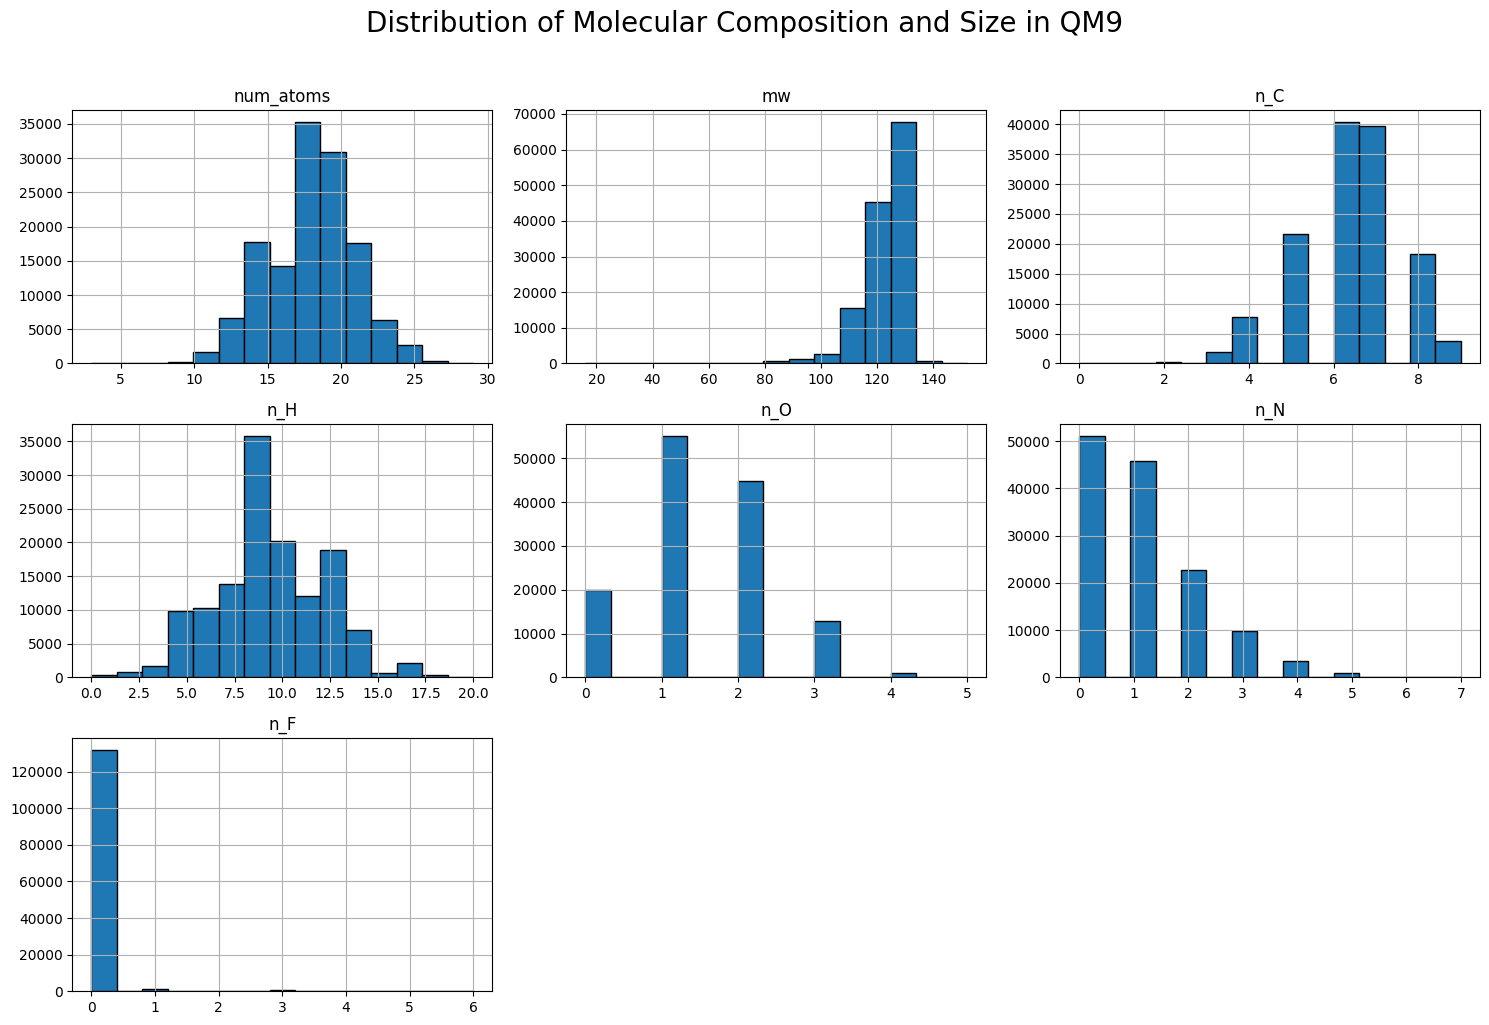

In [54]:
if not df_qm9.empty:
    print("\n\n--- Generating Histograms of Molecular Composition and Size ---")
    composition_cols = ['num_atoms', 'mw', 'n_C', 'n_H', 'n_O', 'n_N', 'n_F']
    df_qm9[composition_cols].hist(bins=15, figsize=(15, 10), layout=(3, 3), edgecolor='black')
    plt.suptitle("Distribution of Molecular Composition and Size in QM9", size=20, y=1.02)
    plt.tight_layout()
    plt.show()

**STEP 5: Correlation Analysis**

The final step of the script consists of a correlation analysis. The script generates and plots a correlation matrix using a ***heatmap*** from the seaborn library.

Correlation measures the strength and direction of the relationship between two variables. Values close to **1** indicate a strong positive correlation (when one increases, the other tends to increase), while values close to **-1** indicate a strong negative correlation (when one increases, the other tends to decrease). A value close to **0** indicates that there is no linear correlation.

In this analysis, the script correlates all 15 extracted quantum properties, in addition to the number of atoms and molecular weight. This visualization is invaluable for:

* Identifying redundancies: If two properties are highly correlated, one of them may be redundant in machine learning models.
* Understanding fundamental relationships: For example, we can expect molecular weight to be strongly correlated with the number of atoms, and the matrix will confirm this visually.

The heat map encodes these correlations by color, making the visualization intuitive and powerful. From this analysis, it is possible to make informed decisions about feature selection for machine learning models, avoiding problems such as multicollinearity.



--- Generating Correlation Matrix ---


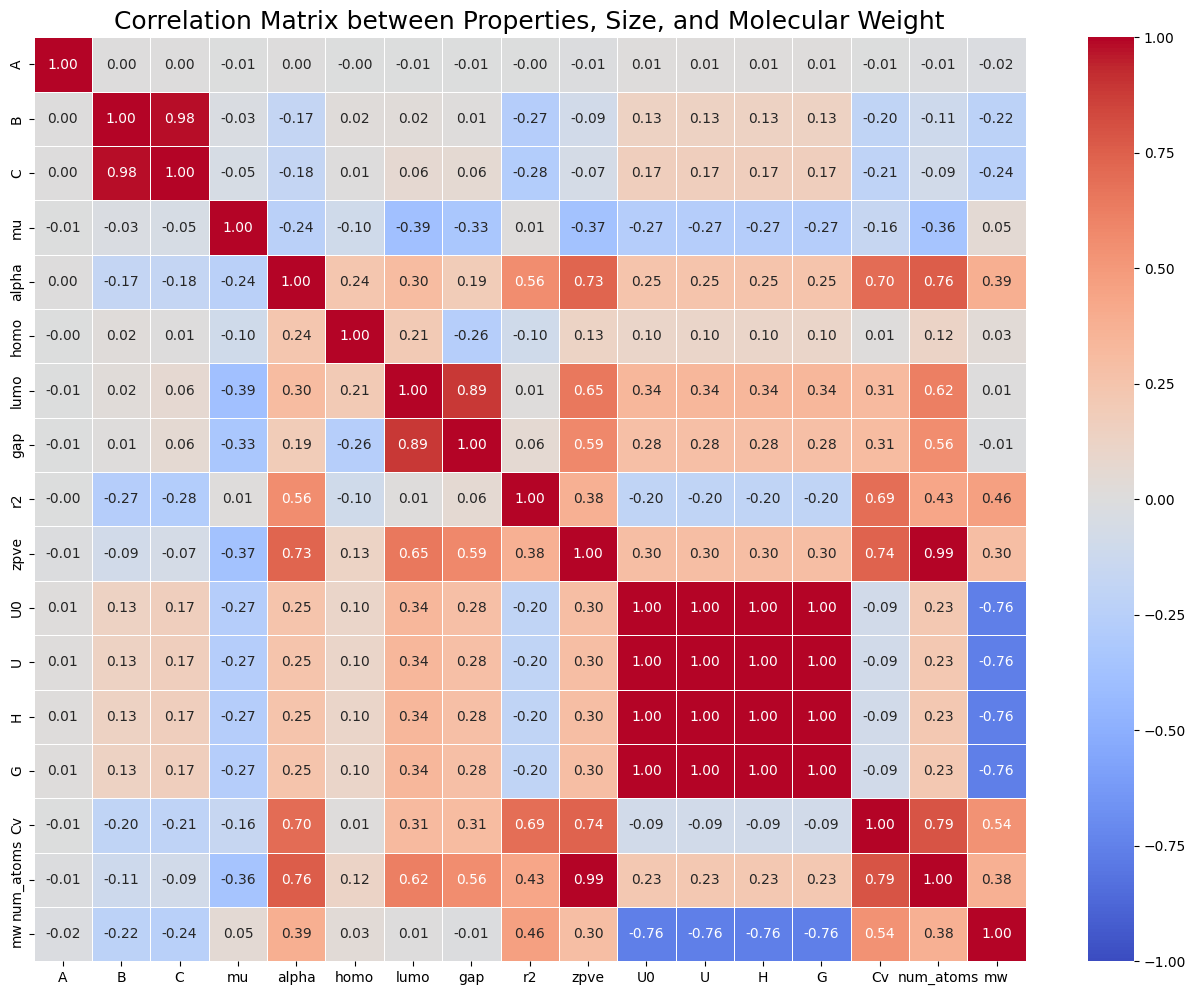

In [55]:
if not df_qm9.empty:
    print("\n\n--- Generating Correlation Matrix ---")
    correlation_cols = property_cols + ['num_atoms', 'mw']
    corr_matrix = df_qm9[correlation_cols].corr()

    # Plota o mapa de calor
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        linewidths=.5, vmin=-1, vmax=1
    )
    plt.title('Correlation Matrix between Properties, Size, and Molecular Weight', size=18)
    plt.show()